In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

tickers = ['AAPL', 'AMD', 'AMZN', 'CCJ', 'COST', 'GOOG', 'GS', 'JPM', 'LLY', 'META', 'MSFT', 'NEE', 'PFE', 'SAP', 'WMT']

In [2]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  15 of 15 completed


,AAPL,AMD,AMZN,CCJ,COST,GOOG,GS,JPM,LLY,META,MSFT,NEE,PFE,SAP,WMT
Date,,,,,,,,,,,,,,,
2023-06-13,183.309998,124.529999,126.660004,31.580000,522.020020,124.430000,342.500000,142.020004,445.720001,271.320007,334.290009,74.349998,40.279999,135.289993,155.300003
2023-06-14,183.949997,127.330002,126.419998,31.209999,527.200012,124.379997,338.420013,141.490005,447.720001,273.350006,337.339996,73.400002,39.360001,135.559998,156.869995
2023-06-15,186.009995,124.239998,127.110001,31.639999,529.179993,125.790001,339.739990,143.089996,453.929993,281.829987,348.100006,74.360001,39.750000,137.039993,157.729996
2023-06-16,184.919998,120.080002,125.489998,31.760000,523.650024,124.059998,338.309998,143.259995,447.709991,281.000000,342.329987,75.589996,40.060001,137.279999,155.529999
2023-06-20,185.009995,118.930000,125.779999,31.950001,519.700012,123.849998,330.720001,142.529999,451.950012,284.329987,338.049988,74.760002,39.340000,136.009995,154.160004


In [3]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.029367
1993-02-01    25.207388
1993-02-02    25.260788
1993-02-03    25.527824
1993-02-04    25.634636
Name: Adj Close, dtype: float64

In [4]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 2909966696448,
 'AMD': 191520129024,
 'AMZN': 1290553131008,
 'CCJ': 13954322432,
 'COST': 230304022528,
 'GOOG': 1568919388160,
 'GS': 109947199488,
 'JPM': 416513982464,
 'LLY': 429023952896,
 'META': 728660967424,
 'MSFT': 2513567219712,
 'NEE': 151270883328,
 'PFE': 222086496256,
 'SAP': 158739988480,
 'WMT': 415128223744}

In [5]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [6]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.5843945301190123

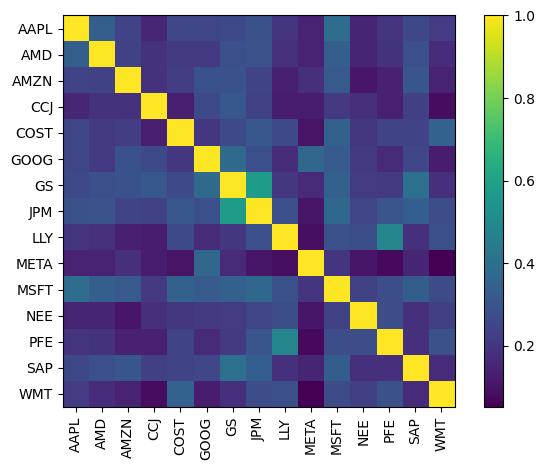

In [7]:
plotting.plot_covariance(S, plot_correlation=True);

In [8]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL    0.193390
AMD     0.155833
AMZN    0.140224
CCJ     0.064951
COST    0.080534
GOOG    0.070711
GS      0.082446
JPM     0.106179
LLY     0.072327
META    0.051492
MSFT    0.132062
NEE     0.052835
PFE     0.071590
SAP     0.086426
WMT     0.077134
dtype: float64

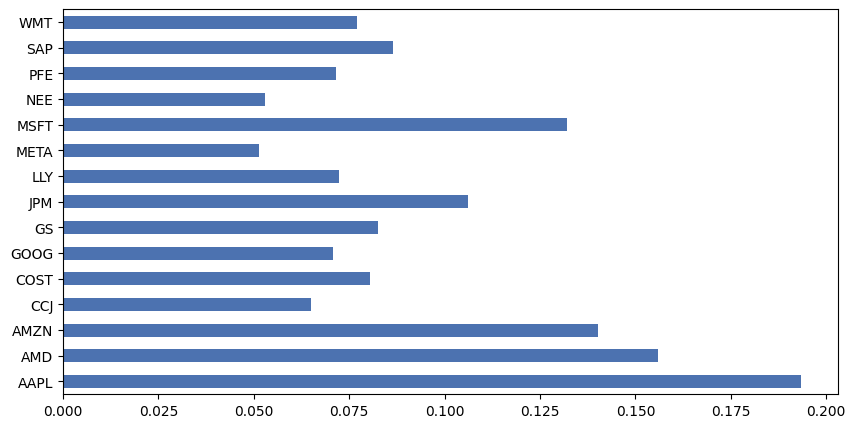

In [9]:
market_prior.plot.barh(figsize=(10,5));

In [10]:
# You don't have to provide views on all the assets
viewdict = {
    "AAPL": 0.03,
    "AMD": 0.10,
    "AMZN": 0.035,
    "CCJ": 0.10,
    "COST": 0.05,
    "GOOG": 0.04,
    "GS": -0.02,
    "JPM": 0.05,
    "LLY": -0.1,
    "META": 0.05,
    "MSFT": 0.20,
    "NEE": 0.12,
    "PFE": -0.08,
    "SAP": -0.04,
    "WMT": 0.03}


bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [11]:
confidences = [
    0.6,
    0.6,
    0.2,
    0.3,
    0.7, # confident in COSTCO
    0.5, 
    0.2, 
    0.4,
    0.3,
    0.5,
    0.4,
    0.6,
    0.3,
    0.6,
    0.4
]

In [12]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

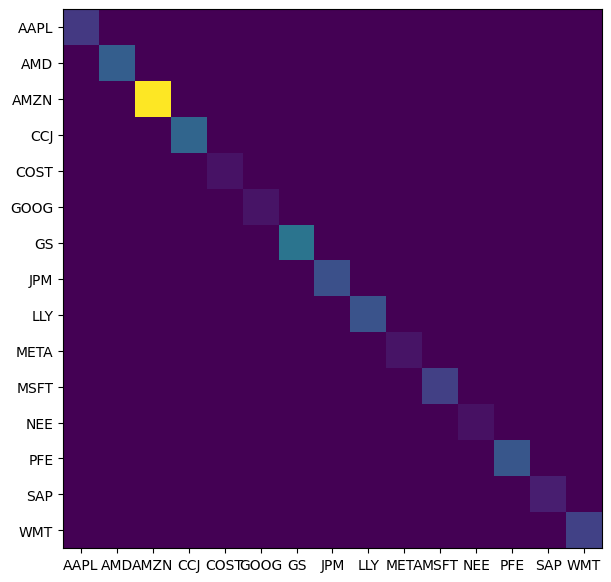

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [14]:
np.diag(bl.omega)

array([0.00553923, 0.0099693 , 0.0332861 , 0.01085813, 0.00156214,
       0.00176699, 0.01283558, 0.00807584, 0.00852747, 0.00180044,
       0.00626517, 0.00152289, 0.00885593, 0.0027759 , 0.00649832])

In [15]:
# intervals = [
#     (0, 0.10),
#     (0, 0.20),
#     (0, 0.1),
#     (0, 0.10),
#     (0, 0.20),
#     (0, 0.20),
#     (-0.20, 0),
#     (0, 0.10),
#     (0, 0.30),
#     (0, 0.10),
#     (0, 0.40),
#     (0, 0.10),
#     (-0.30, 0),
#     (-0.10, 0),
#     (0, 0.10)
# ]

intervals = [
    (-0.03, 0.09),
    (-0.1, 0.3),
    (-0.035, 0.105),
    (-0.1, 0.3),
    (-0.05, 0.15),
    (-0.04, 0.12),
    (-0.02, 0.06),
    (-0.05, 0.15),
    (-0.1, 0.3),
    (-0.05, 0.15),
    (-0.2, 0.6),
    (-0.12, 0.36),
    (-0.08, 0.24),
    (-0.04, 0.12),
    (-0.03, 0.09)
]



In [16]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0036, 0.04000000000000001, 0.004900000000000001, 0.04000000000000001, 0.010000000000000002, 0.0064, 0.0016, 0.010000000000000002, 0.04000000000000001, 0.010000000000000002, 0.16000000000000003, 0.0576, 0.0256, 0.0064, 0.0036]


In [17]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [18]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.065692
AMD     0.069023
AMZN    0.051132
CCJ     0.022481
COST    0.032946
GOOG    0.028793
GS      0.001167
JPM     0.032203
LLY     0.017525
META    0.023273
MSFT    0.066784
NEE     0.018188
PFE     0.013873
SAP     0.004806
WMT     0.029629
dtype: float64

In [19]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.193390,0.065692,0.030
AMD,0.155833,0.069023,0.100
AMZN,0.140224,0.051132,0.035
CCJ,0.064951,0.022481,0.100
COST,0.080534,0.032946,0.050
GOOG,0.070711,0.028793,0.040
GS,0.082446,0.001167,-0.020
JPM,0.106179,0.032203,0.050
LLY,0.072327,0.017525,-0.100
META,0.051492,0.023273,0.050


<Axes: >

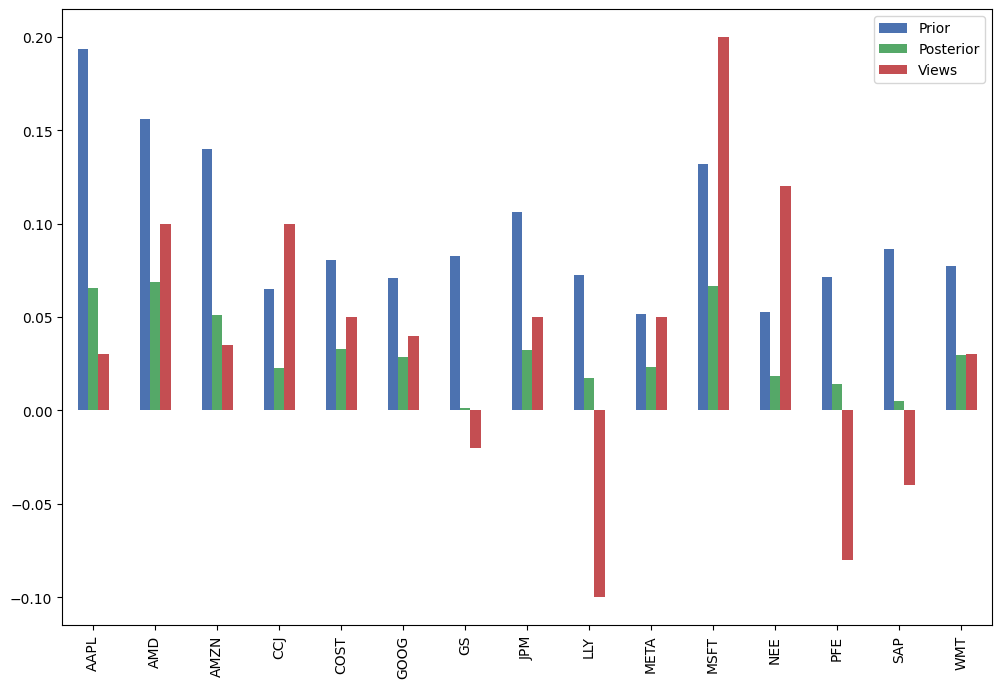

In [20]:
rets_df.plot.bar(figsize=(12,8))

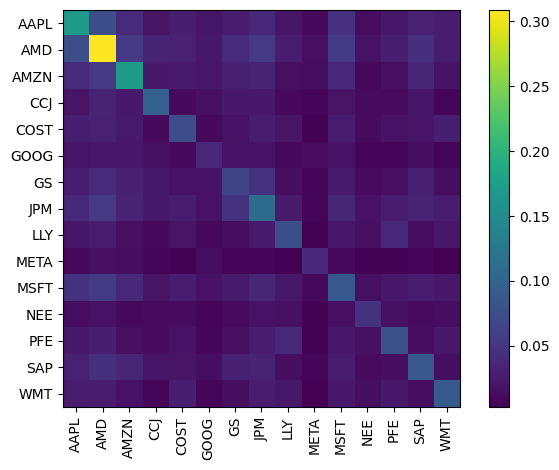

In [21]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [22]:
from pypfopt import EfficientFrontier, objective_functions

In [23]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Python310\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.22107),
             ('AMD', 0.20954),
             ('AMZN', 0.14378),
             ('CCJ', 0.0),
             ('COST', 0.05411),
             ('GOOG', 0.03739),
             ('GS', 0.0),
             ('JPM', 0.03828),
             ('LLY', 0.0),
             ('META', 0.00932),
             ('MSFT', 0.25025),
             ('NEE', 0.0),
             ('PFE', 0.0),
             ('SAP', 0.0),
             ('WMT', 0.03628)])

<Axes: >

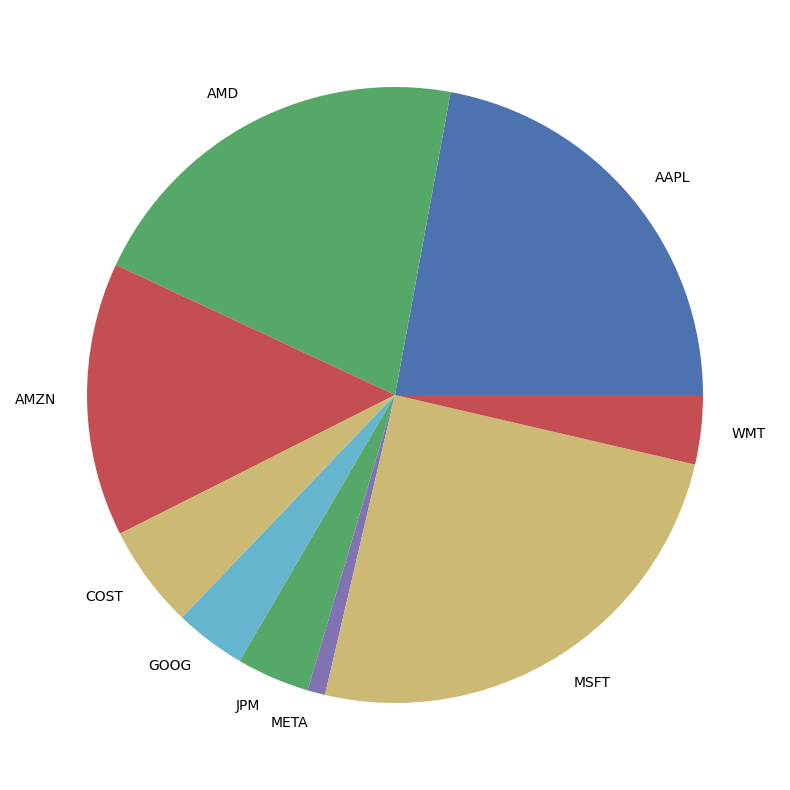

In [24]:
pd.Series(weights).plot.pie(figsize=(10,10))

In [25]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $9.02


{'AAPL': 24,
 'AMD': 35,
 'AMZN': 22,
 'COST': 2,
 'GOOG': 6,
 'JPM': 5,
 'META': 1,
 'MSFT': 15,
 'WMT': 5}